In [13]:
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import numpy as np

Batch_Size=15
Image_Size=256
Channels=3
Epochs=30


dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "D:/VSCode/AI & ML Project/Dataset/Potato",
    shuffle=True,
    image_size=(Image_Size,Image_Size),
    batch_size= Batch_Size
)

Found 1544 files belonging to 3 classes.


In [14]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [15]:
def get_dataset_split(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+val_split+test_split)==1
    ds_size= len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=10)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,test_ds,val_ds

train_ds,test_ds,val_ds = get_dataset_split(dataset)
print(len(train_ds),len(test_ds),len(val_ds))

82 11 10


In [16]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)#loading to cache memory to reduce training time
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

resize_and_rescale =tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),#resizing
    layers.experimental.preprocessing.Rescaling(1.0/255)#normalizing
])

data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomZoom(0.3)
])

input_shape=(Batch_Size,Image_Size,Image_Size,Channels)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),#relu makes model non linear by converting negative values in feature map to 0
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

data=model.fit(
    train_ds,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1,
    epochs=Epochs
)

Epoch 1/30


82/82 [==============================] - 50s 581ms/step - loss: 0.9358 - accuracy: 0.4939 - val_loss: 0.9564 - val_accuracy: 0.4000
Epoch 2/30
82/82 [==============================] - 47s 569ms/step - loss: 0.7782 - accuracy: 0.6371 - val_loss: 0.6210 - val_accuracy: 0.7133
Epoch 3/30
82/82 [==============================] - 47s 568ms/step - loss: 0.6177 - accuracy: 0.7217 - val_loss: 0.6454 - val_accuracy: 0.6733
Epoch 4/30
82/82 [==============================] - 46s 566ms/step - loss: 0.5963 - accuracy: 0.7307 - val_loss: 0.8969 - val_accuracy: 0.6200
Epoch 5/30
82/82 [==============================] - 46s 561ms/step - loss: 0.5415 - accuracy: 0.7510 - val_loss: 0.6847 - val_accuracy: 0.6533
Epoch 6/30
82/82 [==============================] - 46s 561ms/step - loss: 0.4649 - accuracy: 0.8096 - val_loss: 0.3125 - val_accuracy: 0.8467
Epoch 7/30
82/82 [==============================] - 46s 560ms/step - loss: 0.3966 - accuracy: 0.8308 - val_loss: 0.2203 - val_accuracy: 0.9133
Epoch 8/30

In [18]:
model.save("D:/VSCode/AI & ML Project/models/potato")

INFO:tensorflow:Assets written to: D:/VSCode/AI & ML Project/models/potato\assets


INFO:tensorflow:Assets written to: D:/VSCode/AI & ML Project/models/potato\assets


In [19]:
scores=model.evaluate(test_ds)

11/11 [==============================] - 2s 117ms/step - loss: 0.0171 - accuracy: 1.0000


1/1 [==============================] - 0s 187ms/step
Predicted Disease Potato___Late_blight


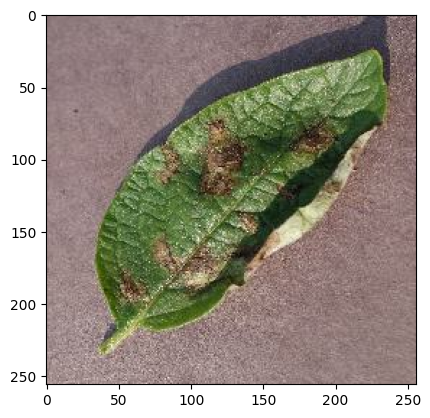

In [20]:
model=tf.keras.models.load_model("D:/VSCode/AI & ML Project/models/potato")

for images_batch,labels_batch in test_ds.take(1):
    image=images_batch[0].numpy().astype("uint8")
    plt.imshow(image)

batch_prediction= model.predict(images_batch)
print("Predicted Disease",class_names[np.argmax(batch_prediction[0])])